In [1]:
"""
# Old code that's too slow
l = []
begin = file_info['Sample Beginning Index']
bytes_per_sample = file_info['Block Align (bytes per sample)']
end = file_info['Sample Beginning Index'] + file_info['Num Samples'] * bytes_per_sample

for i in range(begin, end, bytes_per_sample):
    l.append(int.from_bytes(b[i: i + 2], "little", signed=True))

if (len(l) % 1024 != 0):
    for i in range(1024 - (len(l)%1024)):
        l.append(0)

assert len(l)%1024 == 0, "not padded correctly"
print(len(l))

for i in range(len(nl)):
    assert nl[i] == l[i]

#2048 samples * 96 frequencies* 2 values (sin, cos) * 8 bytes per float ~= 3MB

start = time.time()
#probably a faster way to do this
sample_rate = file_info['Sample Rate'] #Hz

sinmat = np.zeros((96,window))
cosmat = np.zeros((96,window))
for i in range(96):
    # 2 * pi * (note frequency (Hz))/(sampling rate (Hz))
    step = (6.28318530718 * N[Nk[i]][1])/sample_rate 
    radians = np.arange(0, step * window, step, dtype=np.float64)
    sinmat[i] = np.sin(radians)
    cosmat[i] = np.cos(radians)
#     for j in range(sample_len):
#         sinmat[i][j] = sin(j * freq)
#         cosmat[i][j] = cos(j * freq)
    
# numpsd = len(nl)//1024 - 1
# gabor = np.zeros((numpsd, 96))
mid = time.time()

rs_samples = np.reshape(samples, (window, len_samples//1024))
sin_s = np.matmul(sinmat, rs_samples)
cos_s = np.matmul(cosmat, rs_samples)
psd = (sin_s**2 + cos_s**2)
psd /= np.amax(psd)

# #probably a faster way to do this as well
# for i in range(numpsd):
#     s = i * 1024
#     e = s + 2048
#     si = np.matmul(sinmat, nl[s:e])
#     ci = np.matmul(cosmat, nl[s:e])
#     psd = (si**2 + ci**2)
#     gabor[i] = np.copy(psd)

# gabor /= np.amax(gabor)
end = time.time()
print("time taken to generate matrices: {}".format(mid-start))
print("time taken to do fourier transform: {}".format(end-mid))
print("total time: {}".format(end-start))
"""
pass

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
def parse_wav(b):
    assert b[0:4] == b'RIFF', "Chunk ID did not match 'RIFF'"
    chunk_size = int.from_bytes(b[4:8], byteorder="little")
    assert b[8:12] == b'WAVE', "Format did not match 'WAVE'"
    assert b[12:16] == b'fmt ', "Format subchunk ID did not match 'fmt '"
    chunk1_size = int.from_bytes(b[16:20], byteorder="little")
    audio_format = int.from_bytes(b[20:22], byteorder="little")
    assert audio_format == 1, "Audio Format is not PCM (i.e. data is compressed)"
    channels = int.from_bytes(b[22:24], byteorder="little")
    sample_rate = int.from_bytes(b[24:28], byteorder="little")
    byte_rate = int.from_bytes(b[28:32], byteorder="little")
    block_align = int.from_bytes(b[32:34], byteorder="little")
    bits_per_sample = int.from_bytes(b[34:36], "little")
    assert (bits_per_sample % 8) == 0 , "bits per sample is not a multiple of 8"
    assert (sample_rate * (bits_per_sample/8) * channels == byte_rate), "byte_rate != bytes_per_sample * sample_rate * num_channels"
    # from 36 onwards, we might have additional metadata
    data_idx = 36
    while True:
        temp_chunk_id = b[data_idx: data_idx + 4]
        temp_chunk_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
        if temp_chunk_id != b'data':
            data_idx += temp_chunk_size + 8 # add 8 to include the chunk_id and chunk_size fields
        else:
            break
            
    assert b[data_idx: data_idx + 4] == b'data', "Format subchunk ID did not match 'data'"
    sample_size = int.from_bytes(b[data_idx + 4: data_idx + 8], byteorder="little")
    sample_begin = data_idx + 8
    assert sample_size % block_align == 0, "size of sample in bytes is not divisible by number of bytes per sample"
    return {
        "File Size": chunk_size + 8,
        "Audio Format": "PCM",
        "Channels": channels,
        "Sample Rate": sample_rate,
        "Byte Rate": byte_rate,
        "Block Align (bytes per sample)": block_align,
        "Bits Per Sample Per Channel": bits_per_sample,
        "Samples Size": sample_size,
        "Num Samples": int(sample_size/block_align),
        "File Length (seconds)": round(sample_size/(byte_rate), 3),
        "Sample Beginning Index": sample_begin,
    }

In [ ]:
# Clean Code
def gen_psd(byte_arr, window):
    start = time.time()

    file_info = parse_wav(byte_arr)
    num_samples = file_info['Num Samples']
    len_samples = num_samples if (num_samples%window == 0) else (window * (num_samples//window + 1))
    assert len_samples % window == 0
    samples = np.zeros(len_samples, dtype=np.int16)
    samples[:num_samples] = np.frombuffer(byte_arr[file_info['Sample Beginning Index']:], dtype=np.int16)
    samples = samples.astype(np.float64)
    samples /= 2**15 #normalize to [-1,1] range

    mid1 = time.time()

    num_notes = len(pitches)
    sample_rate = file_info['Sample Rate'] #Hz
    sinmat = np.zeros((num_notes, window))
    cosmat = np.zeros((num_notes, window))
    for i in range(num_notes):
        # 2 * pi * (note frequency (Hz))/(sampling rate (Hz))
        step = (6.28318530718 * pitches[i])/sample_rate 
        radians = np.arange(0, step * window, step, dtype=np.float64)[:window] 
        #need [:window] for floating point error
        sinmat[i] = np.sin(radians)
        cosmat[i] = np.cos(radians)   
    rs_samples = np.reshape(samples, (window, len_samples//window))

    mid2 = time.time()

    sin_s = np.matmul(sinmat, rs_samples)/window
    cos_s = np.matmul(cosmat, rs_samples)/window
    #FLOPs = 2 * (96 * window * len_samples/window) + 2 * (96 * len_samples/window) 
    #      = 2 * 96 * (window + 1) * (len_samples/window)
    #      = O(n)
    psd = (sin_s**2 + cos_s**2)**0.5

    end = time.time()

    stats = "read samples: {:.1f}ms \ngenerate matrices: {:.1f}ms \ngemm: {:.1f}ms \ntotal: {:.1f}ms".format(
        1000 * (mid1-start),
        1000 * (mid2-mid1),
        1000 * (end-mid2),
        1000 * (end-start)
    )
    
    return {
        "file_info": file_info,
        "stats": stats,
        "samples": samples,
        "psd": np.transpose(psd),
        "sin": np.transpose(sin_s),
        "cos": np.transpose(cos_s),
    }

def plot_window(n, samples, window):
    plt.figure(figsize=(24,8))
    plt.plot(samples[n*window:(n+1)*window])

In [ ]:
names = ['A','Bb','B','C','Db','D','Eb','E','F','Gb','G','Ab']
all_notes = {}
for i in range(120):
    all_notes[names[i%12] + str(i//12)] = round(27.5*2**(i/12),4)
#Anything above A8 is not very musical, same with things below A2
# https://www.szynalski.com/tone-generator/

WINDOW = 8192 # 1/36 of a second
NOTES = []
for i in range(0, 120):
    NOTES.append((round(27.5*2**(i/12),4), names[i%12] + str(i//12), i))

NAMES = list(zip(*NOTES))[1]
NOTES

NOTES

In [ ]:
pitches = []
for i in range(120):
    base = 27.5*2**(i/12)
    pitches.append(base)
    for j in range(2,20):
        if (base * j < 20000):
            pitches.append(base * j)
        else:
            break

pitches.sort()
pitches = list(filter(lambda x: x < 20000, map(lambda x: round(x, 2), pitches)))
pitches = list(dict.fromkeys(pitches))
pitches

In [ ]:
f = open("sirduke.wav", "rb")
b = f.read()
f.close()

info = gen_psd(b, WINDOW)
print(info['stats'])
print(info['file_info'])

In [ ]:
psd = info['psd']
fig, ax = plt.subplots(figsize=(20,100))
im = ax.imshow(psd[:1000].T)

In [ ]:
def find_peaks(psd_row):
    num_notes = len(pitches)
    assert len(psd_row) == num_notes
    ret = np.zeros(num_notes, dtype=np.uint8)
    if psd_row[0] > psd_row[1]:
        ret[0] = 1
    if psd_row[-1] > psd_row[-2]:
        ret[-1] = 1
    for i in range(1, num_notes-1):
        if psd_row[i-1] < psd_row[i] and psd_row[i+1] < psd_row[i]:
            ret[i] = 1
    return ret

def find_peaks_2(psd_row, top = 16):
    num_notes = len(pitches)
    assert len(psd_row) == num_notes
    ret = np.zeros(num_notes, dtype=np.uint8)
    
    l = list(enumerate(psd_row))
    l.sort(key=lambda x: x[1], reverse=True)
    
    for i in range(top):
        ret[l[i][0]] = 1
    
    return ret
    
find_peaks(psd[50])

In [ ]:
peaks = np.zeros(psd.shape, dtype=np.uint8)
for i,row in enumerate(psd):
    peaks[i] = find_peaks(row)

fig, ax = plt.subplots(figsize=(20,100))
im = ax.imshow(peaks[:200].T)

In [ ]:
def inverse(s_sin, s_cos, peaks, window):
    ret = np.zeros(window, dtype=np.float64)
    sample_rate = 44100
    for i,note in enumerate(pitches):
        if peaks[i] == 1:
            step = (6.28318530718 * note)/sample_rate 
            radians = np.arange(0, step*window, step, dtype=np.float64)[:window]
            ret += ((np.sin(radians) * s_sin[i]) + (np.cos(radians) * s_cos[i]))#amplitude
    return ret

In [ ]:
plt.bar(range(psd.shape[1]),psd[0])

In [ ]:
w = 32
plt.figure(figsize=(24,8))
plt.plot(info['samples'][w*WINDOW:(w+1)*WINDOW])
plt.plot(inv := inverse(info['sin'][w], info['cos'][w], np.ones(len(psd[w]), dtype=np.int8), WINDOW))

In [ ]:
sample2 = np.concatenate([inverse(info['sin'][w], info['cos'][w], find_peaks_2(psd[w], top=4), WINDOW) for w in range(len(psd))], axis=0) * 2**15

In [ ]:
sample2 = sample2.astype(np.int16)

In [ ]:
sample2[:100]

In [ ]:
b[:78]

In [ ]:
f = open("new.wav", "wb")
f.write(b[:78])


In [ ]:
for i in range(info['file_info']['Num Samples']):
    f.write(sample2[i])

In [ ]:
f.close()

In [ ]:
samples = info['samples']

In [ ]:
fi = info['file_info']
fi

In [ ]:
fi['Num Samples'] % 8192

In [ ]:
len(samples) % 8192

In [ ]:
samples

In [4]:
from scipy.fft import rfft, irfft
import math

In [5]:
f = open("orch.wav", "rb")
bb = f.read()
f.close()

window = 1024

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples[:num_samples] = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

num samples:  3395700


In [29]:
def get_percent_yinv(winnum, samples, recon=0.9, window=1504, visual=False):
#     winnum = 58
#     window = 1504 # 47 * 32, alternate value is 1490

    yf = rfft(samples[window*winnum:window*(winnum + 1)])
    ay = np.abs(yf)
    
    if visual:
        plt.figure(figsize=(24,8))
        plt.bar(range(len(yf)), ay)

    l = list(zip(range(len(ay)), ay))
    l.sort(key=lambda x: x[1], reverse=True)

    p1 = 0
    p2 = 0
    num_top = 512
    dnt = 256
    
#     recon = 0.9

    while not(p1 < recon and p2 >= recon):
        yinv_d = None
        yf2 = np.copy(yf)
        top = l[num_top + 1][1]

        for i in range(len(yf2)):
            if np.abs(yf2[i]) <= top:
                yf2[i] = 0
            

        yinv_d = irfft(yf2)
        p2 = 1 - np.linalg.norm(yinv_d-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])

        top = l[num_top][1]
        for i in range(len(yf2)):
            if np.abs(yf2[i]) <= top:
                yf2[i] = 0

        yinv_d = irfft(yf2)
        p1 = 1 - np.linalg.norm(yinv_d-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])
        
        if visual:
            print("reconstruction (num_top + 1), num_top : ", p2, p1, " num_top, dnt: ", num_top, dnt)

        if (p1 >= recon):
            num_top -= dnt
            dnt //= 2
        elif (p2 < recon):
            num_top += dnt
            dnt //= 2
        
        yf2 = None
        yinv_d = None
        
        if (num_top + 1 >= len(l)):
            num_top = len(l) - 2
            break
    
    yf = rfft(samples[window*winnum:window*(winnum + 1)])
    ay = np.abs(yf)

    l = list(zip(range(len(ay)), ay))
    l.sort(key=lambda x: x[1], reverse=True)

    tops = []
    print(len(l), num_top + 1)
    top = l[num_top + 1][1]
    for i in range(len(yf)):
        if np.abs(yf[i]) <= top:
            yf[i] = 0
        else:
            tops.append((i, i * (44100/window), np.abs(yf[i])))
    tops.sort(key=lambda x: x[2], reverse=True)
    
    if visual:
        plt.bar(range(len(yf)), np.abs(yf))

    yinv = irfft(yf)

    pfin = 1 - np.linalg.norm(yinv-samples[window*winnum:window*(winnum + 1)])/np.linalg.norm(samples[window*winnum:window*(winnum + 1)])
    if visual:
        print("final number of entries: ", num_top + 1)
        print("final reconstruction: ", pfin)
    
    return (tops, yinv, pfin)

reconstruction (num_top + 1), num_top :  0.9891023853063168 0.9890773069962651  num_top, dnt:  512 256
reconstruction (num_top + 1), num_top :  0.9316176177639303 0.9312473948625173  num_top, dnt:  256 128
reconstruction (num_top + 1), num_top :  0.8671672630127304 0.8663607526604437  num_top, dnt:  128 64
reconstruction (num_top + 1), num_top :  0.9065432099868961 0.9061151592432364  num_top, dnt:  192 32
reconstruction (num_top + 1), num_top :  0.890413921995859 0.8898222192240617  num_top, dnt:  160 16
reconstruction (num_top + 1), num_top :  0.8992003930968776 0.8987059185096298  num_top, dnt:  176 8
reconstruction (num_top + 1), num_top :  0.9029973810529048 0.9025418454300389  num_top, dnt:  184 4
reconstruction (num_top + 1), num_top :  0.9011280334653581 0.9006523928164873  num_top, dnt:  180 2
reconstruction (num_top + 1), num_top :  0.9001741956517479 0.8996917089723211  num_top, dnt:  178 1
753 179
final number of entries:  179
final reconstruction:  0.9001741956517479


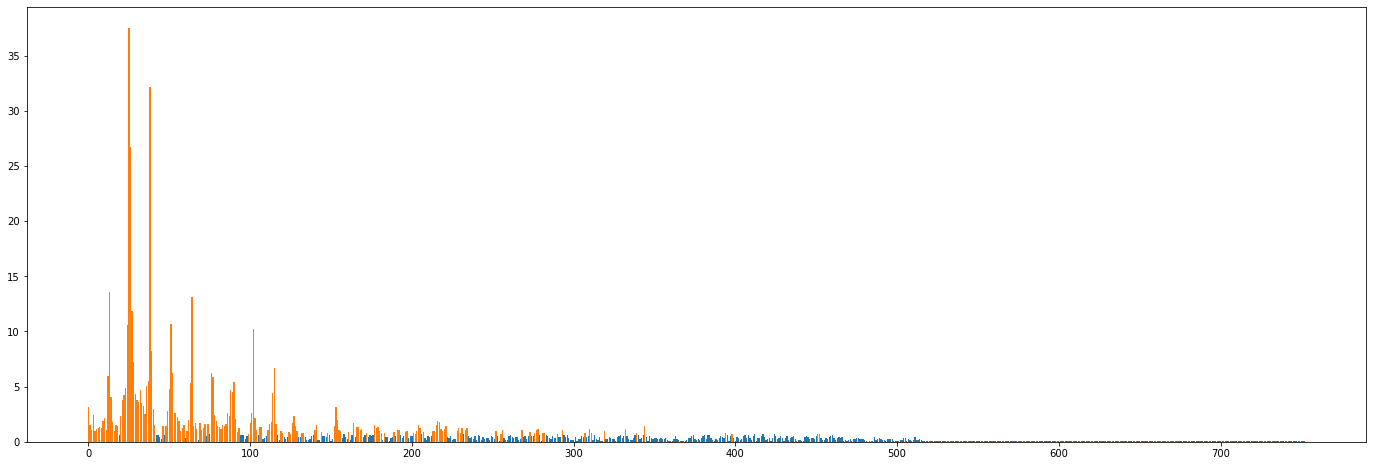

In [30]:
window = 1504
winnum = 48
tops, yinv, pfin = get_percent_yinv(winnum, samples, window=window, visual=True)

1504

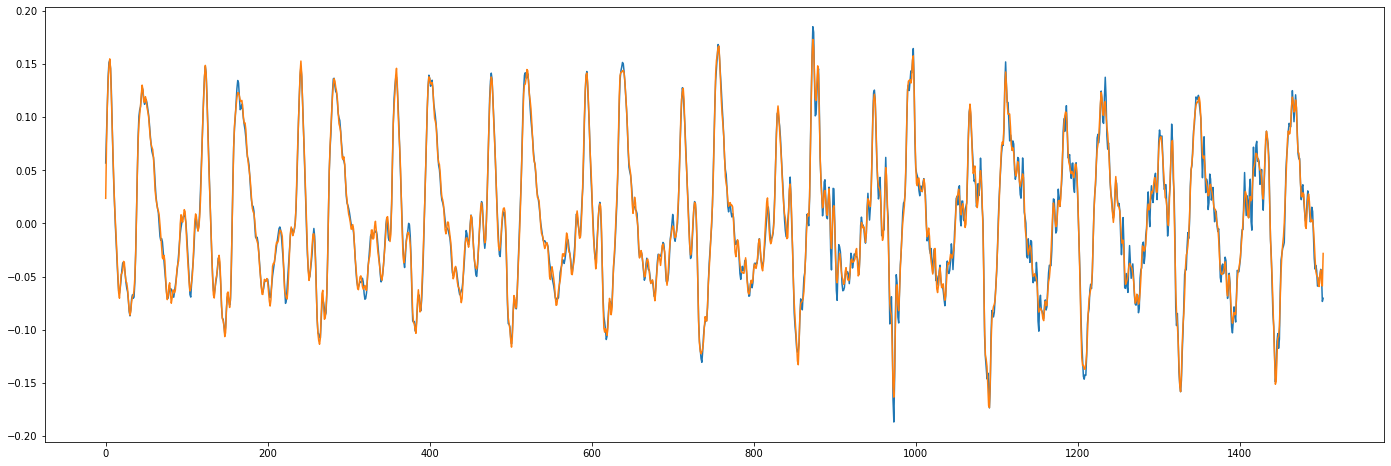

In [31]:
plt.figure(figsize=(24,8))
plt.plot(samples[window*winnum:window*(winnum + 1)])
plt.plot(yinv)
# plt.plot(samples[3439800:3439800+2048])
len(yinv)

In [32]:
f = open("sirduke.wav", "rb")
bb = f.read()
f.close()

window = 1504

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples[:num_samples] = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

ns = num_samples
print(ns)

f = open("new7.wav", "wb")
f.write(bb[:78])

# fft_samples = np.zeros(ns + (window - (ns % window)), dtype=np.int16)

for i in range(0, len(samples), window):
    
    if i % 100 == 0:
        print(i)
    
    if np.linalg.norm(samples[i:i+window]) != 0:
        if num_samples - i >= window:
            tops, yinv, pfin = get_percent_yinv(i//window, samples, window=window, visual=False)

            for j in range(window):
                if (i+j < ns):
                    f.write((yinv[j] * (2**15)).astype(np.int16))
        else:
            for j in range(num_samples - i):
                zero = np.zeros(1, dtype=np.int16)
                if (i+j < ns):
                    f.write((zero[0]).astype(np.int16))
    else:
        for j in range(window):
            zero = np.zeros(1, dtype=np.int16)
            if (i+j < ns):
                f.write((zero[0]).astype(np.int16))

f.close()

num samples:  10255360
10255360
0
753 266
753 108
753 107
753 155
753 169
753 166
753 162
753 152
753 147
753 137
753 227
753 146
753 137
753 117
753 127
753 115
753 151
753 115
753 59
753 55
753 179
37600
753 179
753 139
753 124
753 126
753 133
753 120
753 216
753 208
753 107
753 103
753 92
753 84
753 130
753 94
753 110
753 54
753 165
753 154
753 134
753 117
753 101
753 79
753 77
753 179
753 171
75200
753 95
753 118
753 126
753 165
753 200
753 211
753 155
753 44
753 37
753 171
753 22
753 32
753 10
753 17
753 6
753 7
753 428
753 412
753 378
753 125
753 95
753 367
753 435
753 392
753 308
112800
753 63
753 135
753 120
753 109
753 125
753 29
753 41
753 180
753 392
753 153
753 105
753 93
753 97
753 133
753 401
753 333
753 197
753 60
753 139
753 154
753 151
753 144
753 146
753 97
753 132
150400
753 141
753 276
753 265
753 172
753 176
753 153
753 320
753 401
753 335
753 75
753 84
753 163
753 154
753 140
753 120
753 141
753 146
753 136
753 214
753 261
753 128
753 101
753 111
753 157
753 214
1

753 70
753 59
753 53
753 244
753 160
753 132
1579200
753 154
753 140
753 117
753 104
753 107
753 188
753 93
753 172
753 186
753 235
753 210
753 171
753 183
753 180
753 143
753 193
753 179
753 155
753 134
753 63
753 177
753 159
753 102
753 107
753 113
1616800
753 127
753 160
753 137
753 127
753 183
753 110
753 39
753 55
753 131
753 95
753 94
753 87
753 109
753 132
753 85
753 87
753 114
753 136
753 130
753 134
753 181
753 286
753 279
753 216
753 175
1654400
753 164
753 186
753 211
753 322
753 314
753 166
753 70
753 102
753 82
753 147
753 180
753 174
753 196
753 189
753 150
753 106
753 118
753 87
753 110
753 139
753 156
753 175
753 55
753 46
753 100
1692000
753 108
753 125
753 131
753 197
753 127
753 306
753 289
753 223
753 276
753 234
753 164
753 138
753 137
753 127
753 93
753 62
753 64
753 41
753 57
753 42
753 31
753 45
753 232
753 167
753 103
1729600
753 71
753 83
753 79
753 42
753 37
753 54
753 71
753 127
753 130
753 108
753 81
753 105
753 47
753 31
753 322
753 178
753 246
753 219
753

753 320
753 92
753 304
753 352
753 319
753 294
753 271
753 244
753 277
3120800
753 290
753 255
753 132
753 101
753 84
753 148
753 120
753 127
753 96
753 248
753 276
753 262
753 218
753 220
753 159
753 219
753 242
753 214
753 109
753 102
753 73
753 293
753 191
753 134
753 122
3158400
753 258
753 195
753 168
753 169
753 230
753 174
753 181
753 240
753 282
753 151
753 106
753 177
753 206
753 173
753 130
753 98
753 293
753 264
753 195
753 173
753 152
753 159
753 131
753 258
753 249
3196000
753 131
753 53
753 48
753 275
753 219
753 207
753 52
753 360
753 388
753 366
753 355
753 314
753 235
753 153
753 250
753 180
753 81
753 62
753 83
753 188
753 105
753 70
753 202
753 264
753 278
3233600
753 260
753 248
753 198
753 197
753 254
753 274
753 271
753 186
753 193
753 215
753 203
753 215
753 214
753 218
753 152
753 262
753 238
753 245
753 248
753 191
753 206
753 236
753 296
753 285
753 144
3271200
753 135
753 149
753 265
753 232
753 129
753 138
753 261
753 277
753 254
753 175
753 142
753 161
753 

753 102
753 97
753 52
753 83
753 145
753 135
4662400
753 71
753 171
753 263
753 246
753 213
753 185
753 160
753 123
753 104
753 129
753 134
753 140
753 133
753 75
753 91
753 76
753 93
753 86
753 237
753 158
753 158
753 70
753 57
753 42
753 35
4700000
753 27
753 85
753 105
753 90
753 81
753 82
753 104
753 114
753 113
753 173
753 214
753 105
753 66
753 59
753 95
753 120
753 125
753 194
753 109
753 187
753 137
753 64
753 42
753 54
753 255
4737600
753 124
753 53
753 106
753 153
753 110
753 81
753 161
753 200
753 268
753 206
753 39
753 58
753 72
753 22
753 28
753 17
753 38
753 18
753 56
753 74
753 35
753 90
753 174
753 97
753 132
4775200
753 191
753 257
753 304
753 303
753 285
753 267
753 265
753 265
753 276
753 268
753 290
753 308
753 307
753 321
753 319
753 314
753 323
753 250
753 193
753 249
753 290
753 290
753 278
753 281
753 280
4812800
753 300
753 292
753 300
753 296
753 291
753 262
753 253
753 242
753 227
753 182
753 58
753 140
753 163
753 118
753 107
753 171
753 164
753 237
753 186


753 198
753 161
753 207
753 103
753 126
753 186
753 188
753 162
753 170
753 165
753 157
753 138
753 213
753 220
753 202
753 197
753 213
753 213
753 217
753 214
753 176
753 185
6204000
753 189
753 195
753 176
753 135
753 159
753 223
753 122
753 137
753 144
753 124
753 220
753 226
753 208
753 258
753 208
753 161
753 175
753 175
753 172
753 134
753 174
753 225
753 50
753 122
753 152
6241600
753 141
753 136
753 154
753 179
753 194
753 115
753 147
753 155
753 196
753 273
753 189
753 143
753 323
753 143
753 156
753 148
753 134
753 148
753 191
753 202
753 207
753 230
753 210
753 154
753 129
6279200
753 162
753 223
753 212
753 266
753 192
753 193
753 162
753 186
753 175
753 174
753 155
753 133
753 160
753 141
753 138
753 136
753 99
753 121
753 165
753 154
753 198
753 122
753 150
753 125
753 128
6316800
753 189
753 159
753 159
753 163
753 163
753 160
753 184
753 182
753 111
753 141
753 147
753 109
753 175
753 215
753 228
753 220
753 189
753 146
753 143
753 158
753 64
753 70
753 151
753 168
753 

753 60
753 76
753 53
753 118
753 207
753 176
753 125
753 99
753 85
753 117
753 125
753 74
753 96
753 63
753 96
753 67
753 99
753 124
753 111
753 132
753 114
753 155
7708000
753 132
753 158
753 147
753 112
753 75
753 91
753 130
753 119
753 191
753 200
753 193
753 209
753 225
753 201
753 208
753 169
753 186
753 171
753 162
753 162
753 163
753 160
753 154
753 144
753 201
7745600
753 210
753 202
753 202
753 200
753 198
753 222
753 216
753 194
753 168
753 166
753 176
753 175
753 138
753 137
753 166
753 104
753 160
753 102
753 94
753 133
753 165
753 141
753 191
753 184
753 164
7783200
753 205
753 175
753 188
753 190
753 189
753 77
753 86
753 118
753 154
753 130
753 190
753 203
753 198
753 210
753 105
753 71
753 77
753 110
753 197
753 68
753 82
753 106
753 155
753 145
753 111
7820800
753 163
753 146
753 189
753 176
753 190
753 155
753 180
753 155
753 137
753 153
753 171
753 159
753 146
753 164
753 193
753 147
753 158
753 162
753 144
753 141
753 174
753 147
753 134
753 116
753 107
7858400
753 

753 138
753 139
753 128
753 149
753 168
753 198
753 177
753 169
753 179
753 147
753 144
753 108
753 124
753 84
753 104
753 102
9212000
753 111
753 101
753 105
753 96
753 73
753 64
753 82
753 88
753 102
753 121
753 116
753 78
753 54
753 92
753 66
753 111
753 183
753 96
753 134
753 95
753 88
753 96
753 84
753 92
753 62
9249600
753 68
753 77
753 66
753 87
753 101
753 117
753 178
753 245
753 190
753 159
753 228
753 215
753 177
753 187
753 200
753 159
753 138
753 170
753 164
753 202
753 214
753 200
753 214
753 257
753 200
9287200
753 218
753 241
753 217
753 179
753 190
753 195
753 181
753 172
753 205
753 249
753 236
753 238
753 205
753 135
753 109
753 102
753 110
753 76
753 83
753 75
753 68
753 98
753 126
753 67
753 161
9324800
753 206
753 211
753 209
753 158
753 187
753 184
753 190
753 190
753 197
753 189
753 166
753 156
753 171
753 118
753 87
753 99
753 109
753 109
753 115
753 119
753 166
753 154
753 145
753 139
753 170
9362400
753 161
753 188
753 166
753 118
753 125
753 145
753 133
753 1

In [ ]:
f = open("new4.wav", "rb")
bb = f.read()
f.close()

file_info = parse_wav(bb)

num_samples = file_info['Num Samples']
print("num samples: ", num_samples)
# samples = np.zeros(num_samples + (window - num_samples%window), dtype=np.int16)
samples = np.frombuffer(bb[file_info['Sample Beginning Index']:], dtype=np.int16)
samples = samples.astype(np.float64)
samples /= 2**15

plt.plot(samples[8192 + 1024 + 512:8192 + 512+2048])

In [ ]:
# more fft things now that I realize the number corresponds to how many full cycles in the given time domain
def near(freq):
    ret = []
    for note in NOTES:
        pitch = note[0]
#         if freq/pitch <= 1.029 and pitch/freq >= 0.972: #less than 1/2 away from note
        if freq/pitch <= 1.0195 and pitch/freq <= 1.0195: #less than 1/3 away from note
#         if freq/pitch <= 1.0146 and pitch/freq <= 1.0146: #less than 1/3 away from note
        
            return note[1]
    return None
        
l = []
# for window in range(1024, 2048+1024+1):
window = 1504
sample_rate = 44100
# print("sampling frequency", sample_rate/window, "times per second")
cover = set()
for i in range(1, window//2):
    hz = i * (sample_rate/window)
    note = near(hz)
    if note:
        cover.add(note)
#     print(hz, note)

# print(cover)

note_names = set([n[1] for n in NOTES])
assert cover.issubset(note_names)
missing = list(filter(lambda x: x[-1] in ['3','4','5','6','7'], note_names - cover))
print(len(missing))
missing


In [ ]:
1024 + 128

In [ ]:
note_names = set([n[1] for n in NOTES])
assert cover.issubset(note_names)
missing = list(filter(lambda x: x[-1] in ['3','4','5','6','7'], note_names - cover))
missing

In [ ]:
l = []
sample_rate = 44100
for window in range(1024, 2048+1024+1):
    # window = 1025
    freq = [i * (sample_rate/window) for i in range(1, window+1)]
    match = all_notes['B4']
    closest = map(lambda match: min(map(lambda x: x/match if x >= match else match/x, freq)), [(27.5 * 2**(i/12)) for i in range(24, 96)])
    ans = np.prod(list(closest))
    l.append((window, ans))
l

In [ ]:
l.sort(key=lambda x: x[1])
l

In [ ]:
l.sort(key=lambda x: x[0])

In [ ]:
x = [i[0] for i in l]
y = [i[1] for i in l]
plt.figure(figsize=(24,8))

In [ ]:
plt.plot(y)

In [ ]:
l

In [ ]:
#local minima:
# 1072, 1136, 1203, 1274, 1350, 1430, 1515, 1605, 

In [ ]:
local_min = []
local_min.append(l[0])
for i in range(1, len(l) - 1):
    if l[i-1][1] > l[i][1] and l[i+1][1] > l[i][1]:
        if l[i][1] < local_min[-1][1]:
            local_min.append(l[i])

In [ ]:
local_min

In [ ]:
plt.plot([i[1] for i in local_min])
plt.show()

In [ ]:
# 1135 seems like a good choice, so does 1490
my = max(y)
mx = max(x)

In [ ]:
narr = [(ll[0], int(math.log(ll[0] & -(ll[0]),2)), (my/ll[1])/(ll[0]), ll[1]) for ll in l]

In [ ]:
plt.plot([n[2] for n in narr])
plt.show()

In [ ]:
narr.sort(key=lambda x: x[2], reverse=True)

In [ ]:
narr